In [10]:
! conda install scipy -y -q
! conda install matplotlib -y -q
! conda install pillow -y -q
! conda install PIL -y -q



# All requested packages already installed.
# packages in environment at /home/sanjit/miniconda2/envs/tensorflow:
#
scipy                     1.0.0            py27hf5f0f52_0  


# All requested packages already installed.
# packages in environment at /home/sanjit/miniconda2/envs/tensorflow:
#
matplotlib                2.1.1            py27h0128e01_0  


# All requested packages already installed.
# packages in environment at /home/sanjit/miniconda2/envs/tensorflow:
#
pillow                    4.3.0            py27h353bd0c_1  


Package plan for installation in environment /home/sanjit/miniconda2/envs/tensorflow:

The following NEW packages will be INSTALLED:

    cairo:      1.14.8-0             
    jbig:       2.1-hdba287a_0       
    lcms:       1.19-0               
    libgcc:     7.2.0-h69d50b8_2     
    libiconv:   1.14-0               
    pil:        1.1.7-py27_2         
    pixman:     0.34.0-hceecf20_3    
    pycairo:    1.13.3-py27hea6d626_0

The following packages wi

In [1]:
import tensorflow as tf
import numpy as np
import os

import sys

import scipy

from scipy import ndimage, misc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [2]:
class DataSet(object):
    """Dataset class object."""

    def __init__(self, images, labels, reshape=False):
        """Initialize the class."""
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                images.shape[1] * images.shape[2])

        self._images = images
        self._num_examples = images.shape[0]
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            print "Epochs Completed: ",self._epochs_completed
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end]

In [3]:
height, width = 256/2, 256/2
n_classes = 0

In [14]:
def resize_image(img):
    global height, width
#     return np.array(tf.image.resize_images(img, (height, width)))
    r_img = misc.imresize(img,(height,width,3))
#     print r_img.shape
    return r_img

def replace_cmd_line(output):
    """Replace the last command line output with the given output."""
    sys.stdout.write(output)
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()

def LoadData(path, isTrain=False):
#     data = torchvision.datasets.ImageFolder(path)
    
    classes = os.listdir(path)    
    
    if isTrain:
        global n_classes
        n_classes = len(classes)
    
    if isTrain:
        prompt="Loading Training Data: "
    else:
        prompt="Loading Testing Data: "
    n = 0
    images = []
    labels = []
    for label in classes:
        for img_file in os.listdir(path + label)[:50]:
            img = ndimage.imread(path+label+"/"+img_file,mode='RGB')
#             print img.shape,
            images.append(resize_image(img))
            replace_cmd_line(prompt+label+' '+img_file)
            labels.append(n)
        n+=1
            
    images = np.array(images)
    labels = np.array(labels)
    labels = np.identity(len(classes))[labels]
    
    print prompt+"Done"+" "*30
    
    return DataSet(images, labels)

In [15]:
trainset = LoadData("../data/faces_images/train/", True)
testset = LoadData("../data/faces_images/test/")

/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/home/sanjit/miniconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Loading Training Data: Done                              
Loading Testing Data: Done                              


In [16]:
trainset.images.shape, trainset.labels.shape, testset.images.shape, testset.labels.shape

((325, 128, 128, 3), (325, 10), (96, 128, 128, 3), (96, 10))

## Prameters

In [17]:
batch_size = 32
steps = 1000

n_input = height * width
print n_classes,n_input

10 16384


In [18]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1],padding='SAME')

In [19]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.as_default()

In [20]:
# Graph Input
x = tf.placeholder(tf.float32, [None, height,width,3], name="input_features")
y = tf.placeholder(tf.float32, [None, n_classes], name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# layer 1 ?x128x128x3 => ?x64x64x64
W_conv1 = weight_variable([3,3,3,64])
b_conv1 = bias_variable([64])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name="h_conv1")
h_pool1 = max_pool_2x2(h_conv1)

# layer 2 ?x64x64x64 => ?x32x32x128
W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name="h_conv2")
h_pool2 = max_pool_2x2(h_conv2)

# layer 3 ?x32x32x128 => ?x16x16x256
W_conv3 = weight_variable([3,3,128,256])
b_conv3 = bias_variable([256])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, name="h_conv3")
h_pool3 = max_pool_2x2(h_conv3)

# layer 4 ?x16x16x256 => ?x8x8x512
W_conv4 = weight_variable([3,3,256,512])
b_conv4 = bias_variable([512])

h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4, name="h_conv4")
h_pool4 = max_pool_2x2(h_conv4)

# fully connected layer 1  ?x8x8x512 => ?x1024
W_fc1 = weight_variable([8*8*512,1024])
b_fc1 = bias_variable([1024])

h_pool4_flat = tf.reshape(h_pool4, [-1, 8*8*512], name="flattened_pool_layer")
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat,W_fc1) + b_fc1, name="h_fc1")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")

# fully connected layer 2   ?x1024 => ?xn_classes
W_fc2 = weight_variable([1024,n_classes])
b_fc2 = bias_variable([n_classes])
y_conv = tf.matmul(h_fc1_drop ,W_fc2) + b_fc2

In [21]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv), name="cross_entropy")
train_step = tf.train.AdamOptimizer(learning_rate=0.01,name="optimizer").minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name="accuracy")

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("log", y_conv.graph);

In [22]:
# saver = tf.train.Saver()
# saver.restore(sess, "saved models/model"+str(n_classes)+".ckpt")

In [23]:
graphx = []
graphy = []
for i in range(steps+1):
    batch = trainset.next_batch(batch_size)
#     print i,
    if i%10==0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0}, session=sess)
        print('step %d, training accuracy %g' % (i, train_accuracy))
        graphx.append(i)
        graphy.append(train_accuracy*100)
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob:0.5}, session=sess)

step 0, training accuracy 0
Epochs Completed:  1
step 10, training accuracy 0.03125


KeyboardInterrupt: 

[0.0, 3.125]


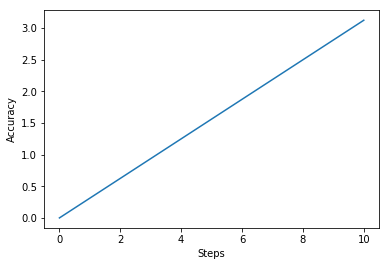

In [24]:
print graphy
plt.plot(graphx,graphy)
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.show()

In [25]:
test_accuracy = accuracy.eval(feed_dict={x: testset.images, y: testset.labels, keep_prob: 1.0}, session=sess)
print 'test accuracy %g' % test_accuracy

test accuracy 0.15625


In [26]:
saver = tf.train.Saver()
saver.save(sess, "saved models/model"+str(n_classes)+".ckpt")

'saved models/model10.ckpt'